# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [238]:
# import libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
pd.set_option('display.max_colwidth',True)

In [328]:
# loading messages and categories datasets
messages = pd.read_csv('disaster_messages.csv')
categories = pd.read_csv('disaster_categories.csv')

## Exploratory Data Analysis (EDA)

### Let's learn more about each dataframe and possible issues.

In [329]:
# Checking the last rows of the dataset
# Why did tail() get so lonely at the party? 
# Because everyone was too busy using head() to notice it!

In [330]:
print(f'There are {messages.shape[0]} rows and {messages.shape[1]} columns in the messages df')

There are 26248 rows and 4 columns in the messages df


In [331]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        26248 non-null  int64 
 1   message   26248 non-null  object
 2   original  10184 non-null  object
 3   genre     26248 non-null  object
dtypes: int64(1), object(3)
memory usage: 820.4+ KB


### The `original` attribute has a significant number of missing values, let's look into it.

In [332]:
messages.isnull().any()

id          False
message     False
original    True 
genre       False
dtype: bool

In [333]:
print(f"The 'original' attribute has {round(messages['original'].isnull().sum()/messages.shape[0],2)*100}% of missing values.")

The 'original' attribute has 61.0% of missing values.


In [334]:
messages.head(2)

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that could pass over Haiti,Un front froid se retrouve sur Cuba ce matin. Il pourrait traverser Haiti demain. Des averses de pluie isolee sont encore prevues sur notre region ce soi,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct


### The `message` attribute provides a translation of the `original` and it is consistently populated in English. Considering the high percentage of missing values, it would be best to drop this column.

In [335]:
messages.drop('original', axis=1, inplace=True)
messages.reset_index(drop=True, inplace=True)

In [336]:
messages.head(2)


,id,message,genre
0,2,Weather update - a cold front from Cuba that could pass over Haiti,direct
1,7,Is the Hurricane over or is it not over,direct


### Let's also look for possible duplicates

In [337]:
# Checking rows with duplicated id and messages
messages[messages.duplicated(subset='id', keep=False)].sort_values(by='id', ascending=False).tail()

,id,message,genre
710,862,What is the address of the radio station? I ask because I need to drop off a file for the committee we created. Thanks in advance!,direct
656,804,elle est vraiment malade et a besoin d'aide. utilisez mon numero de tlphone pour obtenir plus de renseignements. Nous attendons une reponse. Aucun numero fourni par contre.,direct
655,804,elle est vraiment malade et a besoin d'aide. utilisez mon numero de tlphone pour obtenir plus de renseignements. Nous attendons une reponse. Aucun numero fourni par contre.,direct
163,202,?? port au prince ?? and food. they need goverment aid and international aid thak you. god bless haiti,direct
162,202,?? port au prince ?? and food. they need goverment aid and international aid thak you. god bless haiti,direct


In [338]:
# checking for records that have more than 1 duplicated record
messages.groupby('id').filter(lambda x: len(x) > 2)


,id,message,genre
21358,24779,"Shelter materials (thick polyesters) are being distributed to 18,000 households.",news
21359,24779,"Shelter materials (thick polyesters) are being distributed to 18,000 households.",news
21360,24779,"Shelter materials (thick polyesters) are being distributed to 18,000 households.",news


### It would make sense to drop duplicate messages

In [339]:
# checking for records that have more than 1 duplicated record
messages.drop_duplicates(inplace=True)
messages.reset_index(drop=True,inplace=True)


In [340]:
# checking that changes took place
messages[messages.duplicated(subset='id', keep=False)].sort_values(by='id', ascending=False).any()

id         False
message    False
genre      False
dtype: bool

In [341]:
messages.head()

,id,message,genre
0,2,Weather update - a cold front from Cuba that could pass over Haiti,direct
1,7,Is the Hurricane over or is it not over,direct
2,8,Looking for someone but no name,direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct
4,12,"says: west side of Haiti, rest of the country today and tonight",direct


### Exploring the genre attribute distribution.

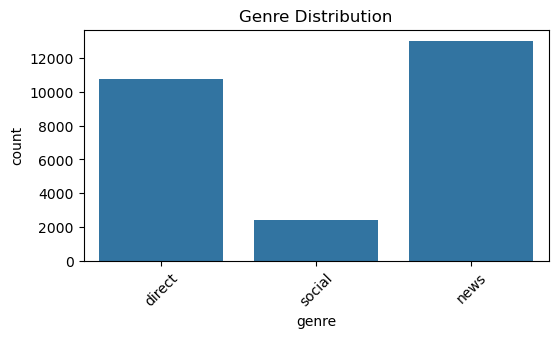

In [342]:
plt.figure(figsize=(6,3))
sns.countplot(x='genre', data=messages)
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.show();

In [343]:
messages.genre.value_counts(normalize=True)

genre
news      0.498052
direct    0.410504
social    0.091444
Name: proportion, dtype: float64

### It looks like most of the messages come either via news or direct showing an imbalance in categories.

### Let's `explore` the categories dataset.

In [344]:

categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
1,7,related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-1;floods-0;storm-1;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
2,8,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
3,9,related-1;request-1;offer-0;aid_related-1;medical_help-0;medical_products-1;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-1;transport-0;buildings-1;electricity-0;tools-0;hospitals-1;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
4,12,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0


In [345]:
print(f'This dataset has {categories.shape[0]} rows and {categories.shape[1]} columns.')

This dataset has 26248 rows and 2 columns.


In [346]:
# Checking for possible missing values
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          26248 non-null  int64 
 1   categories  26248 non-null  object
dtypes: int64(1), object(1)
memory usage: 410.2+ KB


### It appears that this dataset has multi-lable econding in single column meaning that the entire set of categories is stored in the column `categories` with each category-label separated by a semicolon. Transformations are required to restructure the dataset into a more analyzable format, where each category is represented as an individual column with binary values indicating presence or absence.

In [347]:
# Split the 'categories' column into separate category columns
categories_split = categories['categories'].str.split(';', expand=True)

# Extract category names from the first row and set them as column headers
category_colnames = categories_split.iloc[0].str.split('-').str[0]
categories_split.columns = category_colnames

# Convert category values to integers by extracting the numeric part from each string
categories_split = categories_split.apply(lambda col: col.str.split('-').str[1].astype(int))

# Drop the initial 'categories' column and replace it with the new category columns
categories.drop('categories', axis=1, inplace=True)
categories = pd.concat([categories, categories_split], axis=1).reset_index(drop=True)




In [348]:
# Checking transformations took place
categories.head()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Let's check for possible duplicates.

In [349]:
categories[categories.duplicated(subset='id', keep=False)].sort_values(by='id', ascending=False)

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
25242,29119,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25241,29119,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25156,29022,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25155,29022,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24856,28687,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,862,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
656,804,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
655,804,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,202,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [350]:
# checking for records that have more than 1 duplicated record
categories.groupby('id').filter(lambda x: len(x) > 2)



,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
21358,24779,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21359,24779,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21360,24779,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [351]:
# Removing duplicates
categories.drop_duplicates(subset='id',inplace=True)
categories.reset_index(drop=True,inplace=True)


In [352]:
# Checking transformation took place
categories[categories.duplicated(subset='id', keep=False)].sort_values(by='id', ascending=False)

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report


## Data Pre-Processing
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`

In [353]:
# Checking if the two dataframes have the same shape
messages.shape, categories.shape

((26180, 3), (26180, 37))

In [354]:
df = pd.merge(messages, categories, on='id', suffixes=('', '_cat'))
df.head(3)

,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
df.shape

(26180, 39)

## Saving the clean dataset into an sqlite database.

- Using the python built-in module sqlite3 
- Combining sqlite3 with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) 

In [311]:
conn = sqlite3.connect('DisasterResponse.db')
df.to_sql('disaster_messages', conn, if_exists='replace', index=False)
# to_sql automatically commits so no need for conn.commit()
conn.close()

### 8. Use this notebook to complete `process_data.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `process_data.py` in the classroom on the `Project Workspace IDE` coming later.